## COCO Data loader for LUAB

### requirements
- cv2
- json
- torch
- torchvision
- matplotlib

### Initial settings

In [1]:
import numpy as np
import cv2
import json
import random

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torchvision.transforms import functional as tv_f
from matplotlib import pyplot as plt

In [2]:
COCO_CLASS_NAMES = """person
bicycle
car
motorcycle
airplane
bus
train
truck
boat
traffic light
fire hydrant
street sign
stop sign
parking meter
bench
bird
cat
dog
horse
sheep
cow
elephant
bear
zebra
giraffe
hat
backpack
umbrella
shoe
eye glasses
handbag
tie
suitcase
frisbee
skis
snowboard
sports ball
kite
baseball bat
baseball glove
skateboard
surfboard
tennis racket
bottle
plate
wine glass
cup
fork
knife
spoon
bowl
banana
apple
sandwich
orange
broccoli
carrot
hot dog
pizza
donut
cake
chair
couch
potted plant
bed
mirror
dining table
window
desk
toilet
door
tv
laptop
mouse
remote
keyboard
cell phone
microwave
oven
toaster
sink
refrigerator
blender
book
clock
vase
scissors
teddy bear
hair drier
toothbrush
hair brush""".split('\n')


COLOR_PRESET = [
    (255,0,0),
    (0,255,0),
    (0,0,255),
    (255,255,0),
    (255,0,255),
    (0,255,255),
    (255,255,255),
]

In [16]:
def t2n(t):
    return t.detach().cpu().numpy().astype(np.float)


class RandomResizedCropWithCoords(transforms.RandomResizedCrop):
    def __init__(self, **kwargs):
        super(RandomResizedCropWithCoords, self).__init__(**kwargs)

    def __call__(self, img):
        i, j, h, w = self.get_params(img, self.scale, self.ratio)
        coords = [i / img.size[1],
                  j / img.size[0],
                  h / img.size[1],
                  w / img.size[0]]
        return tv_f.resized_crop(img, i, j, h, w, self.size,
                                 self.interpolation), coords
    
    
class RandomHorizontalFlipWithCoords(
    torchvision.transforms.RandomHorizontalFlip):
    def __init__(self, **kwargs):
        super(RandomHorizontalFlipWithCoords, self).__init__(**kwargs)

    def __call__(self, img, coords):
        if random.random() < self.p:
            coords[1] = 1. - coords[1] - coords[3]  # = 1 - j - w
            return tv_f.hflip(img), coords, True
        return img, coords, False

    
class ComposeWithCoords(torchvision.transforms.Compose):
    def __init__(self, **kwargs):
        super(ComposeWithCoords, self).__init__(**kwargs)

    def __call__(self, img):
        is_flip = False
        for t in self.transforms:
            if type(t).__name__ == 'RandomResizedCropWithCoords':
                img, coords = t(img)
            elif type(t).__name__ == 'RandomHorizontalFlipWithCoords':
                img, coords, is_flip = t(img, coords)
            else:
                img = t(img)
        return img, coords, is_flip

    
class CocoMultiClsWeakMixSup(datasets.coco.CocoDetection):
    def __init__(self, root, annFile, transform=None, 
                 target_transform=None, transforms=None):
        super(CocoMultiClsWeakMixSup, self).__init__(
            root=root, annFile=annFile, transform=transform,
            target_transform=target_transform, transforms=transforms)
        if target_transform is not None:
            raise ValueError("Only support target_transform = None. Sorry.")
        if transforms is not None:
            raise ValueError("Only support transforms = None. Sorry.")

        self.ids = list(self.coco.imgs.keys())
        self.cat2cat = dict()
        for cat in sorted(self.coco.cats.keys()):
            self.cat2cat[cat] = len(self.cat2cat)

        self.weak_coco = self._get_weak_coco()

    def _get_weak_coco(self):
        with open('instances_train2014_metadata.json') as f:
            mturk_data = json.load(f)

        mturk_dict = {}
        for annotation in mturk_data:
            mturk_dict[annotation['image_id']] = annotation

        weak_coco = {}
        for key, item in mturk_dict.items():
            weak_coco[key] = {}
            for action in item['actionHistories']:
                if action['actionType'] == 'add':
                    cat_id = COCO_CLASS_NAMES.index(action['iconType'])+1
                    point_y = int(action['pointTo']['y'] * item['originalImageHeight'])
                    point_x = int(action['pointTo']['x'] * item['originalImageWidth'])
                    weak_coco[key][cat_id] = np.array([point_y, point_x])        
        return weak_coco

    def _get_image_target(self, index):
        img_or_tuple, target = super(CocoMultiClsWeakMixSup,
                                     self).__getitem__(index)
        img, coords_ijhw, is_flip = img_or_tuple
        return img, coords_ijhw, target, is_flip

    def get_rrc_coordinates(self, index, coords_ijhw):
        height = self.coco.imgs[self.ids[index]]['height']
        width = self.coco.imgs[self.ids[index]]['width']
        return (int(coords_ijhw[0] * height),
                int(coords_ijhw[1] * width),
                int(coords_ijhw[2] * height),
                int(coords_ijhw[3] * width),
                height,
                width)

    def __getitem__(self, index):
        img, coords_ijhw, targets, is_flip = self._get_image_target(index)
        l_y, l_x, l_h, l_w, h, w = self.get_rrc_coordinates(index, coords_ijhw)

        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        imgAnnots = self.coco.loadAnns(ann_ids)
        
        points = torch.zeros(160, dtype=torch.float32) - 1
        target = torch.zeros(80, dtype=torch.float32)

        turkerAnnots = self.weak_coco[img_id] \
            if img_id in self.weak_coco.keys() else {}

        for idx_object in range(len(imgAnnots)):
            category_id = imgAnnots[idx_object]['category_id']
            mapped_id = self.cat2cat[category_id]
            if category_id in turkerAnnots.keys():
                point_y, point_x = turkerAnnots[category_id]
                if is_flip:
                    point_x = w - point_x
                if (l_y <= point_y <= l_y + l_h) and (
                        l_x <= point_x <= l_x + l_w):
                    points[mapped_id * 2] = (point_y - l_y) / l_h
                    points[mapped_id * 2 + 1] = (point_x - l_x) / l_w
                    target[mapped_id] = 1.0
            else:
                target[mapped_id] = 1.0
        return img, target, points, index
    

### Building a data loader

In [33]:
DATASET_MEAN = [0.485, 0.456, 0.406]
DATASET_STD = [0.229, 0.224, 0.225]
IMAGE_SIZE = 224
RRC_MINIMUM = .08

root = '/home/dataset/coco2014-weak-v03/train2014'
annFile = '/home/dataset/coco2014-weak-v03/annotations/instances_train2014.json'
#root = '/my/data/path/train2014'
#annFile = '/my/data/path/annotations/instances_train2014.json'

transform = ComposeWithCoords(transforms=[
    RandomResizedCropWithCoords(size=IMAGE_SIZE,
                                scale=(RRC_MINIMUM, 1)),
    RandomHorizontalFlipWithCoords(),
    transforms.ColorJitter(0.4, 0.4, 0.4),
    transforms.ToTensor()])

train_loader = torch.utils.data.DataLoader(
        CocoMultiClsWeakMixSup(root, annFile, transform), 
        batch_size=128,
        shuffle=False,
        num_workers=4, pin_memory=True,
        sampler=None)

loading annotations into memory...
Done (t=6.32s)
creating index...
index created!


### Visualizing the image and point

In [34]:
def draw_text(img, text, height, width,
          font=cv2.FONT_HERSHEY_PLAIN,
          pos=(0, 0),
          font_scale=1,
          font_thickness=1,
          text_color=(0, 0, 255),
          text_color_bg=(0, 0, 0),
          ):

    x, y = pos
    text_size, _ = cv2.getTextSize(text, font, font_scale, font_thickness)
    text_w, text_h = text_size
    if x + text_w > width:
        x = x - text_w
    if y + text_h > height:
        y = y - text_h
    cv2.rectangle(img, (x,y), (x + text_w, y + text_h), text_color_bg, -1)
    cv2.putText(img, text, (x, y + text_h + font_scale - 1), font, font_scale, text_color, font_thickness)

    return text_size

In [35]:
for batch in train_loader:
    break

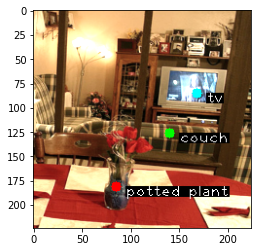

In [36]:
i = 19

img = np.transpose((t2n(batch[0][i])*255).astype(np.uint8), (1,2,0)).copy()
category = t2n(batch[1][i])
point = t2n(batch[2][i])

cat2cat = dict((v, k) for k, v in train_loader.dataset.cat2cat.items())

categories = np.where(category == 1)[0]
for i, target_idx in enumerate(categories):
    point_y = int(point[target_idx*2]*224)
    point_x = int(point[target_idx*2+1]*224)
    class_name = COCO_CLASS_NAMES[cat2cat[target_idx]-1]
    img = cv2.circle(img, (point_x, point_y), thickness=-1, lineType=8, 
                               radius=5, color=COLOR_PRESET[i][::-1])
    draw_text(img=img, text=class_name, width=224, height=224, pos=(point_x+10, point_y),
                     text_color=(255,255,255),
                     text_color_bg=(0,0,0),
                     font_scale=1,
                     font_thickness=1)    

plt.imshow(img)